<a href="https://colab.research.google.com/github/thedstrat/Machine-Learning-Python-Projects/blob/master/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Classification using a CNN pretrained with ImageNet weights. Pull and classify images directly from Google Images.

In [3]:
!pip install google_images_download #Install GI DL module. Do I have to do this every time?

    100% |████████████████████████████████| 911kB 22.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/23/84/3cec6d566b88bef64ad727a7e805f6544b8af4a8f121f9691c
Successfully built google-images-download


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate 
from google.colab import drive
import os
from google_images_download import google_images_download 

In [0]:
bs = 64 #what was this for again?

In [6]:
#Mount Drive and show the directory
drive.mount('/content/drive')
!ls "/content/drive/My Drive/ColabNotebooks/Fastai_1/Images" #Navigate to the right directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
 bun   cupcake	 models   muffin  'small cake'


In [0]:
path = "/content/drive/My Drive/ColabNotebooks/Fastai_1/Images/"

In [0]:
#Download images from Google Images into folder(s) in Google Drive
response = google_images_download.googleimagesdownload() #class instantiation

arguments = {'keywords': 'muffin', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
arguments2 = {'keywords': 'cupcake', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
arguments3 = {'keywords': 'bun', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}
arguments4 = {'keywords': 'small cake', 'limit': 100, 'format': 'jpg', 'size': 'medium', 'output_directory': path}

'''
paths = response.download(arguments) #Download images and create folders
paths = response.download(arguments2)
paths = response.download(arguments3)
paths = response.download(arguments4)
'''

In [0]:
#Create ImageDataBunch class to prep your images for the CNN

#Imagelist.from_folder saves a path attribute of all files that have an image suffix, split into training and cv sets randomly, give label based on the folder name, 
#apply small transformations, binds train/cv/test sets?, and normalizes all colors 

data = (ImageList.from_folder(path).split_by_rand_pct().label_from_folder().transform(get_transforms(), size=224).databunch().normalize(imagenet_stats))

In [0]:
#Show a random sample of images with their actual labels
data.show_batch(rows=3, figsize=(7,6))

In [11]:
#Train the classifier as CNN with 34 layers. The resnet34 model comes pretained w/ Imagenet weights** (This is why it's so good oob)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 32718698.03it/s]


In [0]:
#I think this tells us more information about each layer. Not sure if necessary...?
learn.model

In [0]:
#Fit your model using the '1 cycle' policy
learn.fit_one_cycle(5)

In [83]:
#Save the weights so that you can come back to them later
learn.save('trained_model_all_4', return_path = True)

PosixPath('/content/drive/My Drive/ColabNotebooks/Fastai_1/Images/models/trained_model_all_4.pth')

## **Analysis**

In [0]:
#learn.lr_find() #find alpha

#learn.recorder.plot()

learn.recorder.plot_losses() #plot loss over iteration #

#Was it overfit?

In [0]:
#Make a confusion matrix to visualize the most wrongly classified images
interp = ClassificationInterpretation.from_learner(learn)

#Returns most wrongly classified (losses) and their respective indices.
losses, indices = interp.top_losses() 
print(losses,indices)

#len(data.valid_ds)==len(losses)==len(indices) #?

In [0]:
#Plot most wrongly classified images
interp.plot_top_losses(9, figsize=(15,11)) #Note that the algorithm still got all of these right. Might have to increase # of photos or compare less differentiable items.

In [0]:
# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
#What did the model predict incorrectly most often?
interp.most_confused(min_val=2)

# **Fine Tuning**

In [0]:
# This will unfreeze our model so that the weights in each layer may change. When did it ever become frozen? I think it only unfreezes until you run .fit_one_cycle().
learn.unfreeze()

learn.fit_one_cycle(1)

In [0]:
# Load the CNN that you saved before the analysis. Why is this not before the unfreeze?
learn.load('trained_model_all_4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


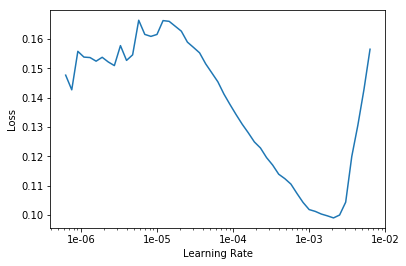

In [24]:
# Find and plot the optimal Learning Rate (alpha)
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.unfreeze() #unfreezing before this significantly improves accuracy

#Pass in the learning rates that minimize our loss using 'max_lr' below. 
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

#WTF. error rate is optimized when max_lr is at highest loss, not lowest. Watch out for this method.

epoch,train_loss,valid_loss,error_rate,time
0,0.170768,0.175206,0.042553,00:10
1,0.128784,0.159222,0.053191,00:11
